In [2]:
import json 
import numpy as np 
import seaborn as sns 
from pathlib import Path 
import matplotlib.pyplot as plt 
import pandas as pd 
import plot_utils
import umap
import networkx as nx 
from sklearn.manifold import TSNE
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

from importlib import reload
reload(plot_utils)

plot_utils.set_style()
ftype = '.pdf'

fig_dir = Path('figs')
fig_dir.mkdir(exist_ok=True, parents=True)


### Functions

In [23]:
def get_params_and_summary(res_dir: Path):
    keys = [
        'bayes_iters', 'max_rxns', 'Number targets', 
        'Cumulative reward of selected compounds', 'Run time', 
        'Expected Reward', 'Number reaction steps (actual)', 'Average reaction score (actual)',
        'max_rxn_classes']

    if not (res_dir / 'params.ini').exists(): 
        return 
    with open(res_dir / 'params.ini', 'r') as f: 
        lines = f.read().splitlines() 
    
    params = {'bayes_iters': 0,}
    for line in lines: 
        p, val = line.split(': ')
        try: 
            val = float(val)
        except: 
            continue  
        params[p] = val

    sol_dir = res_dir/'BEST_SOLUTION' if (res_dir/'BEST_SOLUTION').exists() else res_dir/'solution'
    if not sol_dir.exists(): 
        return 
    
    with open(sol_dir / 'summary.json', 'r') as f:
        summary = json.load(f)
    
    if 'Total Tuning Run Time' in summary: 
        summary['Run time'] = summary['Total Tuning Run Time']
    
    results = {key: val for key, val in {**params, **summary}.items() if key in keys}

    return results

def get_params_only(res_dir: Path): 

    with open(res_dir / 'params.ini', 'r') as f: 
        lines = f.read().splitlines() 
    
    params = {}
    for line in lines: 
        p, val = line.split(': ')
        try: 
            val = float(val)
        except: 
            continue  
        params[p] = val

    return params

def tanimoto_similarity(v1: np.array, v2: np.array):

    # Compute dot products and norms
    dot_product = np.dot(v1, v2)
    norm_vec1 = np.dot(v1, v1)
    norm_vec2 = np.dot(v2, v2)
    
    denom = norm_vec1 + norm_vec2 - dot_product

    return dot_product / denom

def smiles_to_fingerprint_arr(
    smiles_list: list[str],
    radius: int = 3, 
    fpSize: int = 2048,
) -> np.array:
    """ Converts a list of SMILES to a numpy array of fingerprints """

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    fps = [mfpgen.GetCountFingerprintAsNumPy(m) for m in mols]
    return np.asarray(fps, dtype=float)

def fp_featurizer(smiles_list): 
    """ Generates a dictionary mapping SMILES in the design space to count Morgan fingerprints """
    fps = smiles_to_fingerprint_arr(smiles_list)
    featurizer = {
        smi: fps[i,:]
        for i, smi in enumerate(smiles_list)
    }
    return featurizer


### Plotting nonlinear vs linear

In [44]:
sns.color_palette("mako", n_colors=10)

[(0.13701138, 0.08259683, 0.15060265),
 (0.20976258, 0.14925954, 0.29687795),
 (0.25007383, 0.22365053, 0.45519562),
 (0.23807973, 0.32226344, 0.58941872),
 (0.21112526, 0.42903064, 0.6266318),
 (0.20418396, 0.53013715, 0.64946117),
 (0.20968223, 0.63088252, 0.6701105),
 (0.26604085, 0.73564353, 0.67914062),
 (0.4285828, 0.82635051, 0.6780564),
 (0.68051833, 0.88963189, 0.75150483)]

In [ ]:

result_dir = Path('../../../results/automoldesigner_rxnconstr')
data = [
    get_params_and_summary(file) for file in result_dir.glob('*')
]
data = [d for d in data if d]
df = pd.DataFrame(data)
df['Method'] = ['Nonlinear' if d==0 else 'Linear (iterative)' for d in df['bayes_iters'] ]
df = df.sort_values(by='Method')

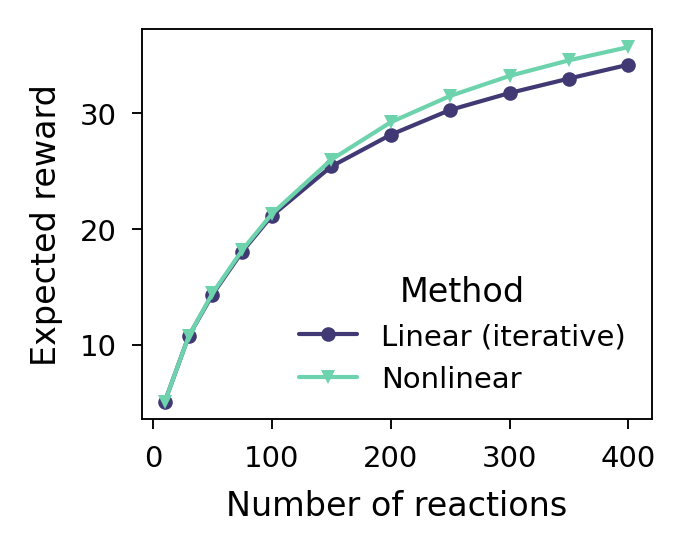

In [46]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df, x='max_rxns', y='Expected Reward', hue='Method', style='Method', ax=ax, 
             palette=method_colors, markers=method_markers, dashes = False, markeredgecolor=None, 
             markeredgewidth=0, markersize=3.5, linewidth=1) 
plot_utils.set_size(ax=ax, w=1.7, h=1.3)
ax.set_xlabel('Number of reactions')
ax.set_ylabel('Expected reward')
fig.savefig(fig_dir/f'er_vs_nrxns{ftype}',bbox_inches='tight', dpi=200, transparent=True)

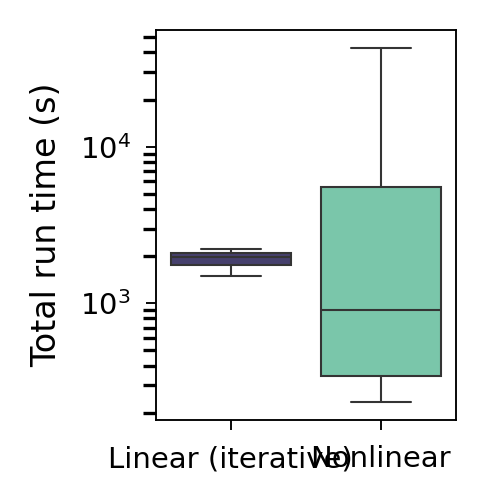

In [47]:
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df, x="Method", y="Run time", hue="Method", ax=ax, linewidth=0.5, fliersize=1, palette=method_colors, log_scale=True)
plot_utils.set_size(ax=ax, w=1, h=1.3)
ax.set_ylabel('Total run time (s)')
ax.set_xlabel(None)
fig.savefig(fig_dir/f'time_vs_method{ftype}',bbox_inches='tight', dpi=200, transparent=True)


In [48]:
df_common = df[['Method', 'max_rxns', 'Number targets']]
storage = []

for i in set(df_common['max_rxns']):
    res_dir_er = result_dir / f'er_{i:0.0f}'
    res_dir_bo = result_dir / f'bo_{i:0.0f}'

    with open(res_dir_er / 'solution' / 'solution_list_format.json', 'r') as f: 
        er_selections = set([entry['smiles'] for entry in json.load(f)['Targets']])

    with open(res_dir_bo / 'BEST_SOLUTION' / 'solution_list_format.json', 'r') as f: 
        bo_selections = set([entry['smiles'] for entry in json.load(f)['Targets']]) 
    
    storage.append({
        'Method': 'Common',
        'max_rxns': i, 
        'Number targets': len(er_selections & bo_selections)
    })

df_count = pd.concat([
    df_common, pd.DataFrame(storage)
])

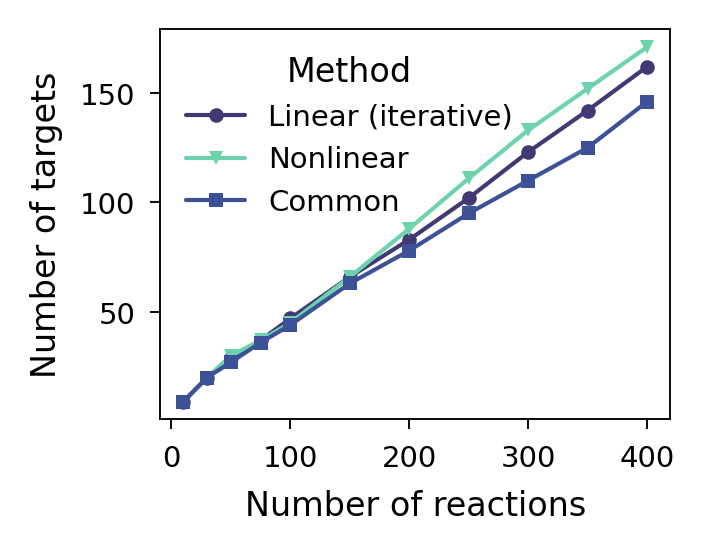

In [49]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df_count, x='max_rxns', y='Number targets', hue='Method', style='Method', ax=ax, 
             palette=method_colors, markers=method_markers, dashes = False, markeredgecolor=None, 
             markeredgewidth=0, markersize=3.5, linewidth=1) 
plot_utils.set_size(ax=ax, w=1.7, h=1.3)
ax.set_xlabel('Number of reactions')
ax.set_ylabel('Number of targets')
fig.savefig(fig_dir/f'targetcount{ftype}',bbox_inches='tight', dpi=200, transparent=True)


### Diversity figures 

In [63]:
method_colors.update({
    'div': sns.color_palette("mako", n_colors=10).as_hex()[3],
    'no_div': sns.color_palette("mako", n_colors=10).as_hex()[8],
})

target_df_clusters = pd.read_csv('../targets_similarity.csv')

# embed all (synthesizable by ASKCOS) targets 
from sparrow.utils import cluster_utils
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')

smi_to_fp = fp_featurizer(target_df_clusters.SMILES)
fps_all = np.array(list(smi_to_fp.values()))

div_result_dir = Path('../../../results/automoldesigner_div')

#### Visualization

In [64]:
with open(div_result_dir / 'weight_0' / 'solution' / 'solution_list_format.json', 'r') as f: 
    sel_smis_0 = [e['smiles'] for e in json.load(f)['Targets']]
# with open(Path('../../../results/automoldesigner_rxnconstr/bo_300') / 'BEST_SOLUTION' / 'solution_list_format.json', 'r') as f: 
#     sel_smis_0 = [e['smiles'] for e in json.load(f)['Targets']]

with open(div_result_dir / 'weight_1.0' / 'solution' / 'solution_list_format.json', 'r') as f: 
    sel_smis_1 = [e['smiles'] for e in json.load(f)['Targets']]


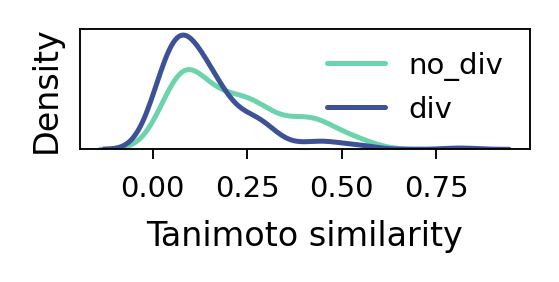

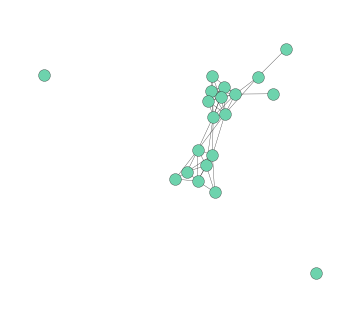

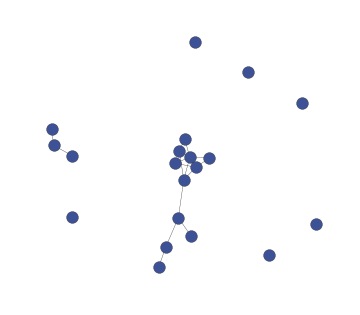

In [82]:
fighist, axhist = plt.subplots(1,1)
for smis, name in zip([sel_smis_0, sel_smis_1], ['no_div', 'div']):
    # Create a graph
    G = nx.Graph()
    tani_min = 0.3

    # Add nodes (sequences) to the graph
    for i, smi in enumerate(smis):
        G.add_node(i, label=str(smi))

    # Add edges based on sequence similarity
    widths = []
    all_sims = []
    for i, smi_1 in enumerate(smis):
        for j, smi_2 in enumerate(smis):
            if i >= j: 
                continue 
            tani_sim = tanimoto_similarity(smi_to_fp[smi_1], smi_to_fp[smi_2])
            all_sims.append(tani_sim)
            if tani_sim > tani_min:
                G.add_edge(i, j, weight=tani_sim)
                widths.append(tani_sim)

    # Visualize the network
    pos = nx.spring_layout(G, seed=0) #, k=1)
    fig, ax = plt.subplots(1,1)
    nx.draw(G, pos, width=0.075,
            node_color=method_colors[name], 
            node_size=8, 
            ax=ax, 
            edgecolors='k', linewidths=0.075)
    plot_utils.set_size(w=1, h=0.85, ax=ax,)
    fig.savefig(fig_dir/f'clustervis_{name}{ftype}',bbox_inches='tight', dpi=200, transparent=True)

# histogram of similarities 
    # fig, ax = plt.subplots(1,1)
    # axhist.hist(all_sims, color=method_colors[name], range=[0,1], linewidth=0.5, edgecolor='black', alpha=0.5)
    sns.kdeplot(data=all_sims, ax=axhist, color=method_colors[name], label=name)

plot_utils.set_size(w=1.5, h=0.4, ax=axhist)
axhist.legend()
axhist.set_xlabel('Tanimoto similarity')
 # axhist.set_ylim([0, 4.3])
axhist.tick_params(left=False)
axhist.set_yticks([])
fighist.savefig(fig_dir/f'tanihist_{name}{ftype}',bbox_inches='tight', dpi=200, transparent=True)


#### Number of clusters vs weighting factor 

In [74]:
smi_to_cluster = {smi: c for smi, c in zip(target_df_clusters.SMILES, target_df_clusters.Cluster) }
storage = []

for res_dir in div_result_dir.glob('*'): 

    sol_folder = 'BEST_SOLUTION' if (res_dir / 'BEST_SOLUTION').exists() else 'solution'

    with open(res_dir / sol_folder / 'solution_list_format.json', 'r') as f: 
        selections = [sel['smiles'] for sel in json.load(f)['Targets']]

    n_clusters = len(set(
        smi_to_cluster[sel] for sel in selections                
    ))

    with open(res_dir / sol_folder / 'summary.json', 'r') as f: 
        summary = json.load(f)

    storage.append({
        'Diversity weight': get_params_only(res_dir)['diversity_weight'],
        'Number of clusters': n_clusters,
        'Number of reactions': summary['Number reaction steps (actual)'], 
        'Average reaction score': summary['Average reaction score (actual)'],
        'Expected reward': summary['Expected Reward'],
    })

df = pd.DataFrame(storage)
    

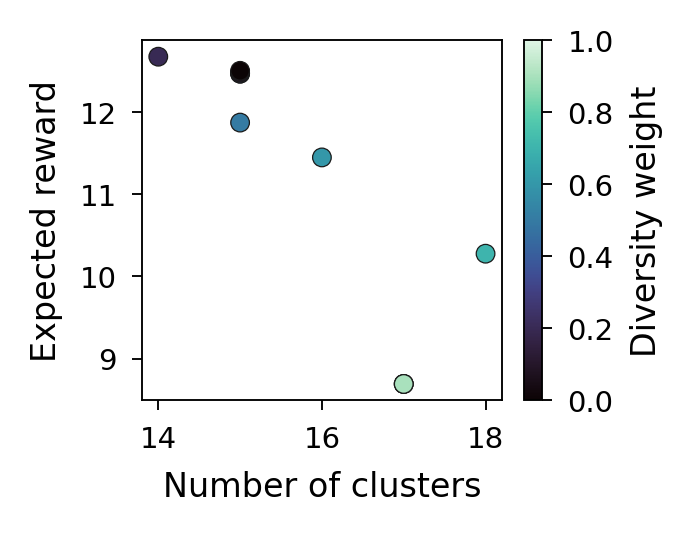

In [75]:
fig, ax = plt.subplots(1,1)
cmap = sns.color_palette('mako', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap) # , norm=mpl.colors.Normalize())
sns.scatterplot(data=df, ax=ax, x='Number of clusters', y='Expected reward', hue='Diversity weight', 
                hue_norm=sm.norm, palette=cmap, s=20, edgecolor='k', linewidth=0.3, legend=False)
plot_utils.set_size(1.5, 1.2, ax=ax)
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('Diversity weight')
fig.savefig(fig_dir/f'div1{ftype}',bbox_inches='tight', dpi=200, transparent=True)


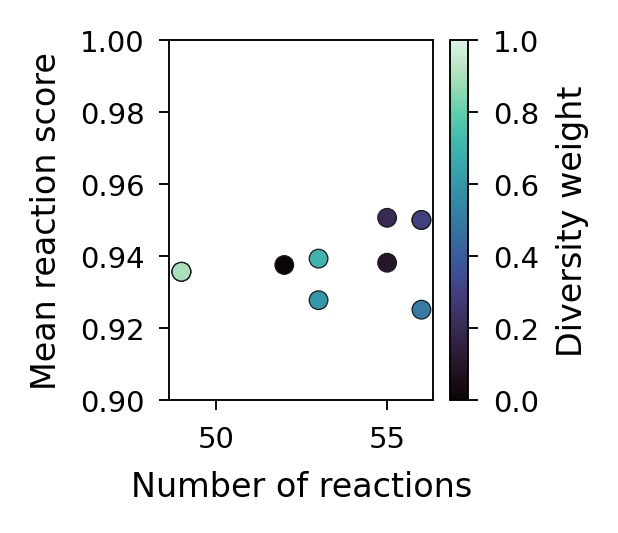

In [78]:
fig, ax = plt.subplots(1,1)
cmap = sns.color_palette('mako', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap) # , norm=mpl.colors.Normalize())
sns.scatterplot(data=df, ax=ax, x='Number of reactions', y='Average reaction score', hue='Diversity weight', 
                hue_norm=sm.norm, palette=cmap, s=20, edgecolor='k', linewidth=0.3, legend=False)
# ax.set_xlim([220, 280])
ax.set_ylim([0.9, 1])
plot_utils.set_size(1.1, 1.2, ax=ax)
ax.set_ylabel('Mean reaction score')
cbar = plt.colorbar(sm, ax = plt.gca())
cbar.set_label('Diversity weight')
fig.savefig(fig_dir/f'div2{ftype}',bbox_inches='tight', dpi=200, transparent=True)


### Reaction classification

#### Expected reward vs number of classes allowed 

In [24]:
storage = []
for res_dir in Path('../../../results/automoldesigner_namerxn_8').glob('*'): 
    storage.append(get_params_and_summary(res_dir))

df_rxn = pd.DataFrame(storage)

NameError: name 'method_markers' is not defined

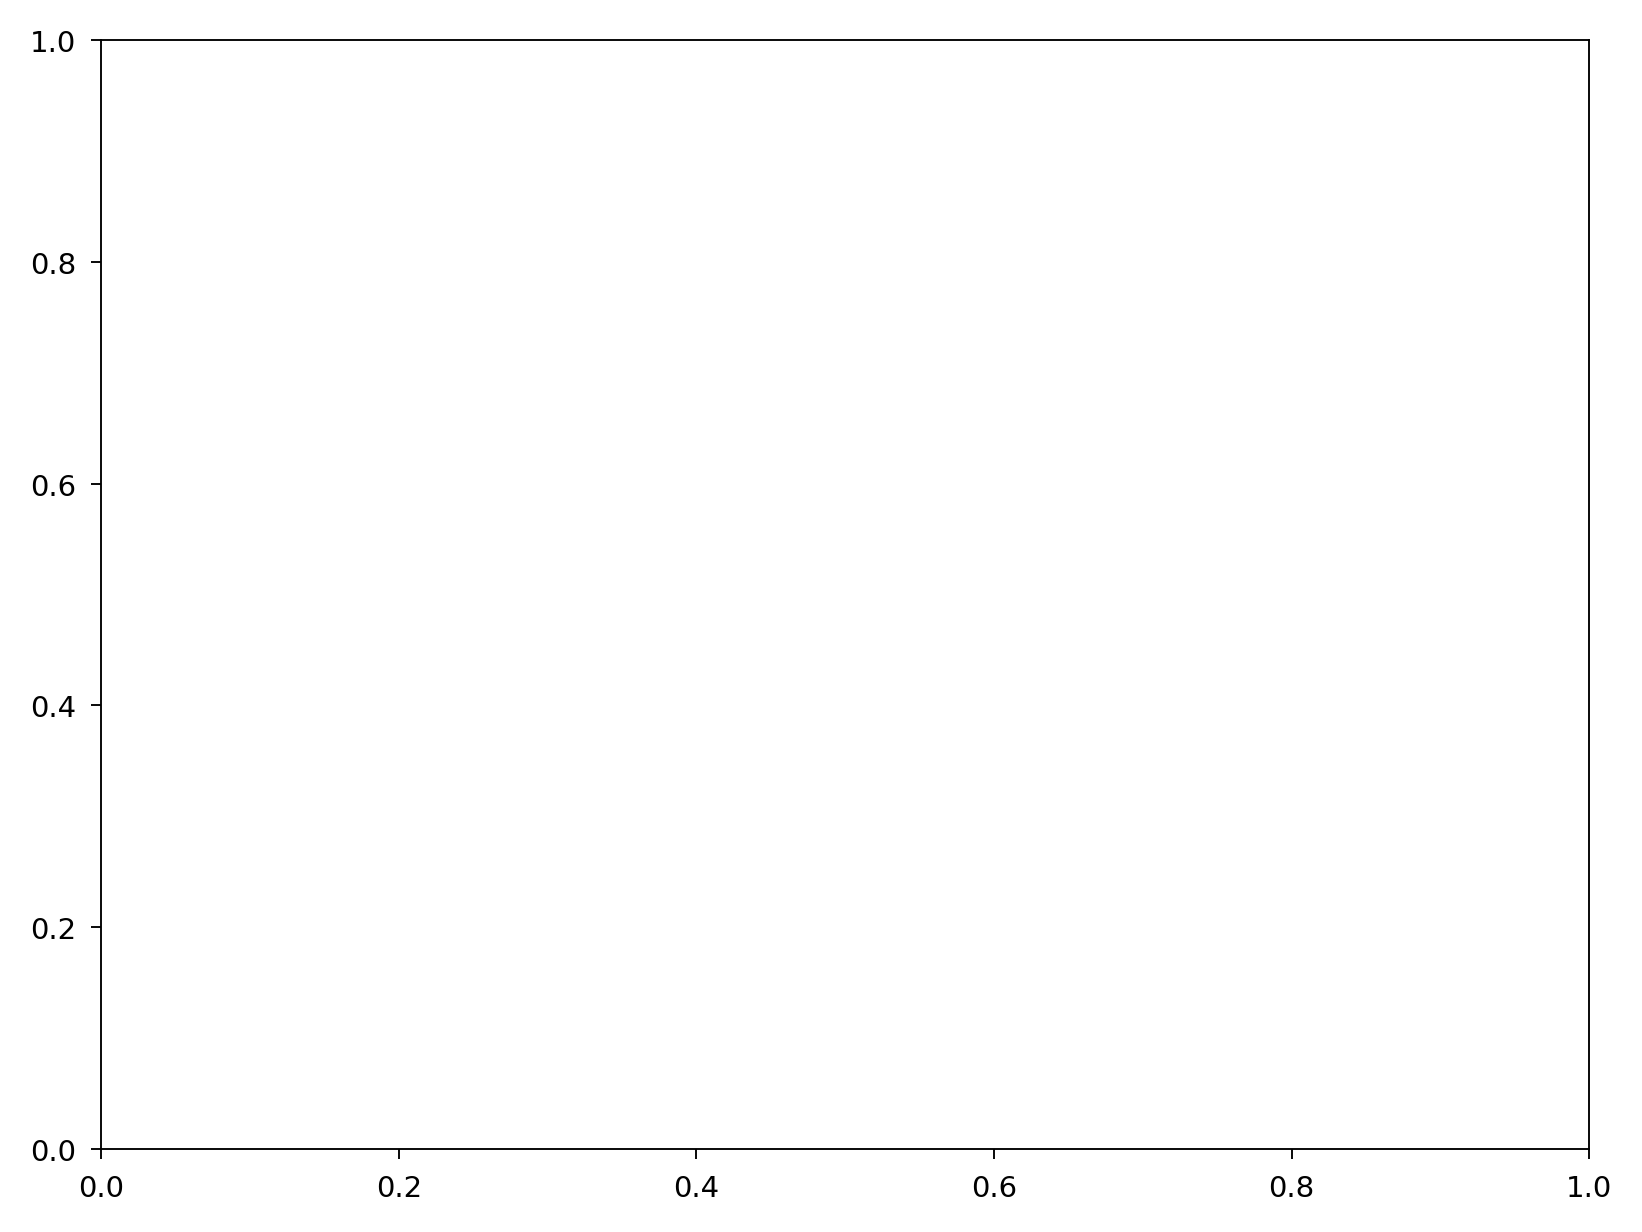

In [25]:
fig, ax = plt.subplots(1,1)
sns.lineplot(data=df_rxn, x='max_rxn_classes', y='Expected Reward', ax=ax, 
             marker=method_markers['Linear (iterative)'], c='gray', 
             dashes = False, markeredgecolor=None, 
             markeredgewidth=0, markersize=5, linewidth=1) 
plot_utils.set_size(ax=ax, w=1.2, h=1.2)
ax.set_xlabel('Reaction classes')
ax.set_ylabel('Expected reward')
fig.savefig(fig_dir/f'er_vs_classes{ftype}',bbox_inches='tight', dpi=200, transparent=True)

In [ ]:
# plot of number of reaction classes vs number of clusters 


### SI tables

In [3]:
name_rxn_mapping = {
    '8.1.4': 'Alcohol to aldehyde oxidation',
    '10.1.2': 'Chlorination',
    '1.2.2': 'Aldehyde reductive imination',
    '1.3.7': 'Chloro N-arylation',
    '1.2.1': 'Aldehyde reductive amination',
    '3.10.1': 'Friedel-Crafts acylation',
    '9.7.12': 'Amino to isothiocyanato',
    '2.3.2': 'Isothiocyanate + amine thiourea coupling',
}

#### SI table for parallel chemistry figure 

In [17]:
paths_names = {
    '../../../results/automoldesigner_namerxn_8/classes_8/BEST_SOLUTION/solution_list_format.json': '8_classes',
    '../../../results/automoldesigner_namerxn_8/classes_1/BEST_SOLUTION/solution_list_format.json': '1_class',
    '../../../results/automoldesigner_namerxn_diversity/div0.1_classes1_tars8_newclusters0.85/solution/solution_list_format.json': '1_class_diversity',
    '../../../results/automoldesigner_namerxn_diversity/div0_classes1_tars8_newclusters0.85/solution/solution_list_format.json': '1_class_no_diversity',
}

clusters = [False, False, True, True]

for (path, label), c in zip(paths_names.items(), clusters):  

    with open(path, 'r') as f: 
        solution = json.load(f)

    if c: 
        cluster_labels = {
            tar['smiles']: tar['clusters'][0]
            for tar in solution['Targets']
        }  
    rewards = {tar['smiles']: tar['reward'] for tar in solution['Targets']}

    storage = []

    for reaction in solution['Reactions']:
        if reaction['smiles'].startswith('>>'): 
            continue 

        prod = reaction['smiles'].split('>>')[-1]
        store = {
            'Reactant SMILES': reaction['smiles'].split('>>')[0],
            'Product SMILES': prod, 
            'Reaction likelihood score': f'{reaction['score']:0.3f}',
            'Reward of reaction product': f'{rewards[prod]:0.3f}' if prod in rewards else '--'
        }
        if c: 
            store['Cluster'] = '--'
            if prod in rewards: 
                store['Cluster'] = cluster_labels[prod].split('SimCluster_')[-1]
        else: 
            store['NameRxn Class'] = name_rxn_mapping[reaction['class'][0]]
        
        storage.append(store)

    df = pd.DataFrame(storage)

    str_df = df.to_latex(escape=False, index=False, multicolumn_format='c')
    outpath = fig_dir / f'si_table_{label}.txt'
    with open(outpath,'w') as f:
        f.writelines(str_df)

In [7]:
solution['Targets']

[{'smiles': 'Cc1cc(Nc2ccc(C#N)cc2C(=O)O)cc(C)c1C',
  'reward': 0.583137035,
  'clusters': ['SimCluster_0']},
 {'smiles': 'CN1CCN(c2nc3ccc([N+](=O)[O-])cc3s2)CC1',
  'reward': 0.001960552,
  'clusters': ['SimCluster_1']},
 {'smiles': 'Nc1ccnc(N2CCC(Oc3ccc(F)cc3F)CC2)c1[N+](=O)[O-]',
  'reward': 0.351116836,
  'clusters': ['SimCluster_0']},
 {'smiles': 'c1nc(N2CCCCC2)nc(N2CCOCC2)n1',
  'reward': 0.001595217,
  'clusters': ['SimCluster_16']},
 {'smiles': 'Cc1nc(N(C)C)nc(N2CCNCC2)n1',
  'reward': 4.49e-05,
  'clusters': ['SimCluster_11']},
 {'smiles': 'COc1cc2nc(N3CCC(N(C)C)C3)nc(N)c2cc1OC',
  'reward': 0.5014956,
  'clusters': ['SimCluster_6']},
 {'smiles': 'FC(F)c1nc(N2CCC(N3CCCC3)CC2)ccc1Cl',
  'reward': 0.000162393,
  'clusters': ['SimCluster_7']},
 {'smiles': 'O=C1NC(=O)C(NCCC2CCCCC2)=C1Cl',
  'reward': 0.028621931,
  'clusters': ['SimCluster_5']}]